# Bias, variance, K-fold cross validation and Leaning curves 

This notebook explores the relationship between the number of K folds, the bias, variance and learning curve for a simple toy data set. The code in python was used to generate the plots and simulations used for the following stats.stackexchange post
- https://stats.stackexchange.com/questions/61546/optimal-number-of-folds-in-k-fold-cross-validation-is-leave-one-out-cv-always/357572?noredirect=1#comment672417_357572

## Question: how to chose K in K-fold cross validation 

# Choosing the number K folds by considering the learning curve
I would like to argue that choosing the appropriate number of $K$ folds can be facilitated by the shape and position of the learning curve. This argument is largely taken from the book "Elements of Statistical Learning" chapter 7.10, page 243. 

> To summarize, if the learning curve has a considerable slope at the
> given training set size, five- or tenfold cross-validation will
> overestimate the true prediction error. Whether this bias is a
> drawback in practice depends on the objective. On the other hand,
> leave-one-out cross-validation has low bias but can have high
> variance.

### A toy example

To understand this argument visually, consider the following toy example where we are fitting a degree 6 polynomial to a noisy sine curve: 

[![enter image description here][1]][1] 

Intuitively and visually, we expect this model to fare poorly for small datasets due to overfitting. This behaviour is reflected in the learning curve where we plot $1 -$ Mean Square Error vs Training size together with $\pm$ 1 standard deviation.  

[![enter image description here][2]][2] 


## The argument

The performance of the model improves significantly as the training size increases to 50 observations. Increasing the number further to 200 brings only small benefits. Consider the following two cases:

1. If our training set had 200 observations, $5$ fold cross validation would estimate the performance over a training size of 160 which is virtually the same as the performance for training set size 200. Thus cross-validation would not suffer from much bias and increasing $K$ to larger values will not bring much benefit (*left hand plot*)

2. However if the training set had $50$ observations, $5$ fold cross-validation would estimate the performance of the model over training sets of size 40, and from the figure that would be an underestimate of 1 − MSE. Hence cross-validation would be biased and increasing $K$ could reduce the bias, perhaps at the expense of greater variance. (*right hand plot*). 


[![enter image description here][3]][3] 


  [1]: https://i.stack.imgur.com/JvpMx.png
  [2]: https://i.stack.imgur.com/o4Wee.png
  [3]: https://i.stack.imgur.com/944NG.png

### Libraries 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.style.use('seaborn-white')
%matplotlib inline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold
from sklearn.metrics import mean_squared_error 

from scipy import interpolate

In [51]:
def generate_data(n_points = 100):
    #np.random.seed(0)
    n = n_points
    x = np.linspace(0,1,n)
    x_plot = np.linspace(0,1,10*n)
    noise = np.random.uniform(-.5,.5, size = n)
    y = np.sin(x * 1 * np.pi  - .5)  
    Y = (y + noise).reshape(-1,1)
    X = x.reshape(-1,1)
    return X,Y

### Viewing the toy data set and degree 6 polynomial regression 

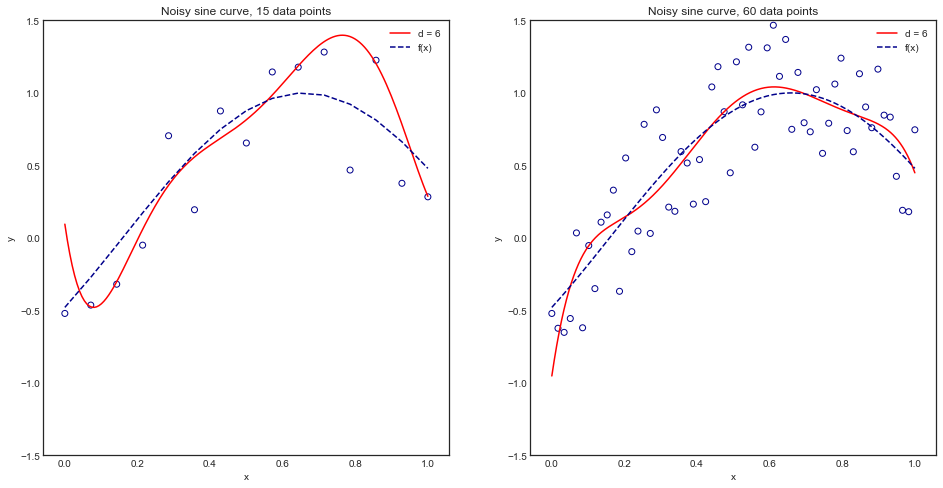

In [2]:
#Initializing noisy non linear data
np.random.seed(35)
n = 15
x = np.linspace(0,1,n)
x_plot = np.linspace(0,1,10*n)
noise = np.random.uniform(-.5,.5, size = n)
y = np.sin(x * 1 * np.pi  - .5)  
y_noise = y + noise

#Split test / train data
X_train, X_test, y_train, y_test = train_test_split(x.reshape(-1,1), y_noise.reshape(-1,1), test_size=0.25, random_state=42)

#Utility variables
degs = np.arange(0,11)
degrees = [6]
Train_MSE_list, Test_MSE_list = [], []

#Setup plot figures
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1, 2, 1)

for d in degs:
    #Create an sklearn pipeline, fit and plot result
    pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures(degree=d, include_bias=True, interaction_only=False)),
     ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])
    
    pipeline.fit(X_train,y_train)
    
    Train_MSE = mean_squared_error(y_train, pipeline.predict(X_train))
    Test_MSE = mean_squared_error(y_test, pipeline.predict(X_test))
    Train_MSE_list.append(Train_MSE)
    Test_MSE_list.append(Test_MSE)

    if d in degrees: 
        plt.plot(x_plot, pipeline.predict(x_plot.reshape(-1,1)), label = 'd = {}'.format(d), color = 'red') 


#First plot left hand side
ax.plot(x,y,color = 'darkblue',linestyle = '--', label = 'f(x)')
ax.scatter(x,y_noise, facecolors = 'none', edgecolor = 'darkblue')
ax.set_title('Noisy sine curve, 15 data points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_ylim(-1.5,1.5)
ax.legend()

#========================== RHS plot ====================#


#Initializing noisy non linear data
np.random.seed(35)
n = 60
x = np.linspace(0,1,n)
x_plot = np.linspace(0,1,10*n)
noise = np.random.uniform(-.5,.5, size = n)
y = np.sin(x * 1 * np.pi  - .5)  
y_noise = y + noise

#Split test / train data
X_train, X_test, y_train, y_test = train_test_split(x.reshape(-1,1), y_noise.reshape(-1,1), test_size=0.25, random_state=42)

ax = fig.add_subplot(1, 2, 2)

for d in degs:
    #Create an sklearn pipeline, fit and plot result
    pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures(degree=d, include_bias=True, interaction_only=False)),
     ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])
    
    pipeline.fit(X_train,y_train)
    
    Train_MSE = mean_squared_error(y_train, pipeline.predict(X_train))
    Test_MSE = mean_squared_error(y_test, pipeline.predict(X_test))
    Train_MSE_list.append(Train_MSE)
    Test_MSE_list.append(Test_MSE)

    if d in degrees: 
        plt.plot(x_plot, pipeline.predict(x_plot.reshape(-1,1)), label = 'd = {}'.format(d), color = 'red') 


#First plot left hand side
ax.plot(x,y,color = 'darkblue',linestyle = '--', label = 'f(x)')
ax.scatter(x,y_noise, facecolors = 'none', edgecolor = 'darkblue')
ax.set_title('Noisy sine curve, 60 data points')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_ylim(-1.5,1.5)
ax.legend()


#plt.legend(loc = 'lower center')
plt.show()

### Learning curve 

Text(0.5,1,'1 - Error (MSE) vs Training size ')

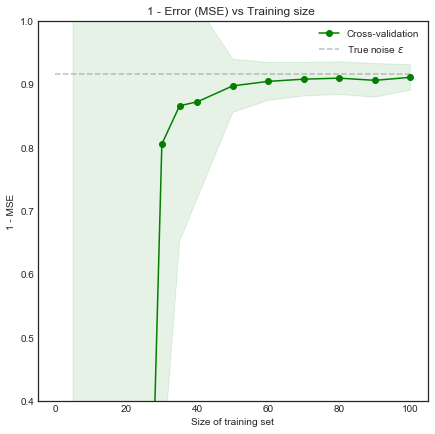

In [89]:
#Initializing noisy non linear data
np.random.seed(0)
n = 10000
x = np.linspace(0,1,n)
x_plot = np.linspace(0,1,10*n)
noise = np.random.uniform(-.5,.5, size = n)
y = np.sin(x * 1 * np.pi  - .5)  
Y = (y + noise).reshape(-1,1)
X = x.reshape(-1,1)

#Utility variables
Train_Mean_MSE, Train_Std_MSE, Test_Mean_MSE, Test_Std_MSE = [],[], [],[]
train_sizes=np.array([5,10,15,20,25,30,35,40,50,60,70,80,90,100])
test_sizes = np.array([1,2,3,4,5,6,7,8,10,12,14,16,18,20])


for s in range(len(train_sizes)):

    Train_MSE_list, Test_MSE_list = [], []
    rs = ShuffleSplit(n_splits=300, train_size = train_sizes[s], test_size=test_sizes[s])
    rs.get_n_splits(X)
    

    for train_index, test_index in rs.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test, y_train, y_test = X[train_index],X[test_index],Y[train_index], Y[test_index] 

        pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures(degree=6, include_bias=True, interaction_only=False)),
         ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])
        pipeline.fit(X_train,y_train)

        #Inner loop results
        Train_MSE_list.append(mean_squared_error(y_train, pipeline.predict(X_train)))
        Test_MSE_list.append(mean_squared_error(y_test, pipeline.predict(X_test)))
    
    #Calculating loop results: mean and std
    Train_Mean_MSE.append(np.mean(Train_MSE_list))
    Train_Std_MSE.append(np.std(Train_MSE_list))
    Test_Mean_MSE.append(np.mean(Test_MSE_list))
    Test_Std_MSE.append(np.std(Test_MSE_list))

#Converting to numpy for convenience
Train_Mean_MSE = np.asarray(Train_Mean_MSE)
Train_Std_MSE = np.asarray(Train_Std_MSE)
Test_Mean_MSE = np.asarray(Test_Mean_MSE)
Test_Std_MSE = np.asarray(Test_Std_MSE)


#Plotting
plt.figure(figsize = (7,7))
plt.fill_between(train_sizes, 1 - (Test_Mean_MSE - Test_Std_MSE),
                 1 - (Test_Mean_MSE + Test_Std_MSE), alpha=0.1, color="g")

plt.plot(train_sizes, 1 - Test_Mean_MSE, 'o-', color="g",
         label="Cross-validation")

plt.hlines(1 - 1/12 , 0,100, linestyle = '--', color = 'gray', alpha = .5, label = 'True noise $\epsilon$')
plt.legend(loc="best")
plt.ylim(0.4,1)
plt.ylabel('1 - MSE')
plt.xlabel('Size of training set')
plt.title('1 - Error (MSE) vs Training size ')



## Increasing K improves bias
### Small dataset  - 40 points

In [155]:
#Utility variables
Test_Mean_MSE1, Test_Std_MSE1 = [],[]
Test_Mean_MSE2, Test_Std_MSE2 = [],[]
split_range = np.arange(2,40,3)

#Looping over Kfold splits (2 to 40 K folds)
for s in split_range:

    for i in range(50):

        Test_MSE_list = []
        
        #Selecting 40 data points (ShuffleSplit is used for convenience)
        rs = ShuffleSplit(n_splits=1, train_size = 40, test_size=1)
        rs.get_n_splits(X)
        for subset_index, _ in rs.split(X):
            X_subset, Y_subset, = X[subset_index],Y[subset_index]
        
        #Setting up Kfolds
        kf = KFold(n_splits = s)
        for train_index, test_index in kf.split(X_subset):
            X_train, X_test = X_subset[train_index], X_subset[test_index]
            y_train, y_test = Y_subset[train_index], Y_subset[test_index]
            
            pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures(degree=6, include_bias=True, interaction_only=False)),
             ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])
            pipeline.fit(X_train,y_train)
            Test_MSE_list.append(mean_squared_error(y_test, pipeline.predict(X_test)))

        #Intermediate loop calculations
        Test_Mean_MSE1.append(np.mean(Test_MSE_list))
        Test_Std_MSE1.append(np.std(Test_MSE_list))
        
    #Outer loop append results
    Test_Mean_MSE2.append(np.mean(Test_Mean_MSE1))
    Test_Std_MSE2.append(np.mean(Test_Std_MSE1))

#For convenience
Test_Mean_MSE2  = np.asarray(Test_Mean_MSE2)
Test_Std_MSE2  = np.asarray(Test_Std_MSE2)


Text(0.5,1,'1 - MSE vs Number of Kfolds: 40 data points, 50 iterations bootstrap ')

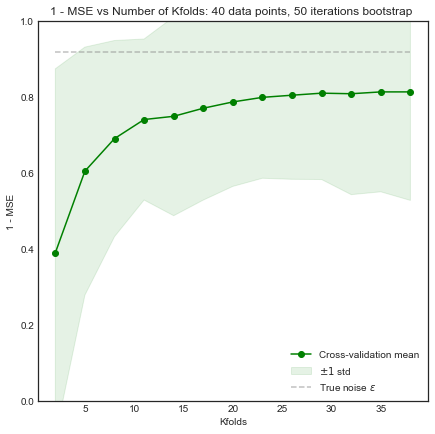

In [156]:
#Plotting result
plt.figure(figsize = (7,7))

plt.fill_between(split_range, 1 - (Test_Mean_MSE2 - Test_Std_MSE2),
                 1 - (Test_Mean_MSE2 + Test_Std_MSE2), alpha=0.1, color="g", label = '$\pm 1$ std')

plt.plot(split_range, 1 - Test_Mean_MSE2, 'o-', color="g",
         label="Cross-validation mean")

plt.hlines(1 - 1/12 , min(split_range),max(split_range), linestyle = '--', color = 'gray', alpha = .5, label = 'True noise $\epsilon$')
plt.legend(loc="lower right")
plt.ylim(0,1)
plt.ylabel('1 - MSE')
plt.xlabel('Kfolds')
plt.title('1 - MSE vs Number of Kfolds: 40 data points, 50 iterations bootstrap ')

### Printing the standard deviation for each K value 

In [160]:
pd.DataFrame(data = {'K = ':split_range,'Mean MSE': Test_Mean_MSE2,'Std MSE': Test_Std_MSE2 })


,K =,Mean MSE,Std MSE
0,2,0.609751,0.483575
1,5,0.395080,0.325931
2,8,0.309614,0.257790
3,11,0.259503,0.211595
4,14,0.251036,0.261278
5,17,0.229814,0.241452
6,20,0.213246,0.221976
7,23,0.201223,0.212663
8,26,0.195605,0.221003
9,29,0.190221,0.226995


## Increasing K increases the variance
### Large dataset - 200 points

In [161]:
#Utility variables
Test_Mean_MSE1, Test_Std_MSE1 = [],[]
Test_Mean_MSE2, Test_Std_MSE2 = [],[]
split_range = np.arange(5,100,10)

for s in split_range:

    for i in range(20):
        Test_MSE_list = []
        rs = ShuffleSplit(n_splits=1, train_size = 200, test_size=1)
        rs.get_n_splits(X)
        for subset_index, _ in rs.split(X):
            X_subset, Y_subset, = X[subset_index],Y[subset_index]
        
        #Loop over kfold splits
        kf = KFold(n_splits = s)

        for train_index, test_index in kf.split(X_subset):
            X_train, X_test = X_subset[train_index], X_subset[test_index]
            y_train, y_test = Y_subset[train_index], Y_subset[test_index]
            
            pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures(degree=6, include_bias=True, interaction_only=False)),
             ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])
            pipeline.fit(X_train,y_train)
            Test_MSE_list.append(mean_squared_error(y_test, pipeline.predict(X_test)))
        
        Test_Mean_MSE1.append(np.mean(Test_MSE_list))
        Test_Std_MSE1.append(np.std(Test_MSE_list))       

    Test_Mean_MSE2.append(np.mean(Test_Mean_MSE1))
    Test_Std_MSE2.append(np.mean(Test_Std_MSE1))

Test_Mean_MSE2  = np.asarray(Test_Mean_MSE2)
Test_Std_MSE2  = np.asarray(Test_Std_MSE2)

Text(0.5,1,'1 - MSE vs Number of Kfolds: 200 data points, 20 iterations bootstrap ')

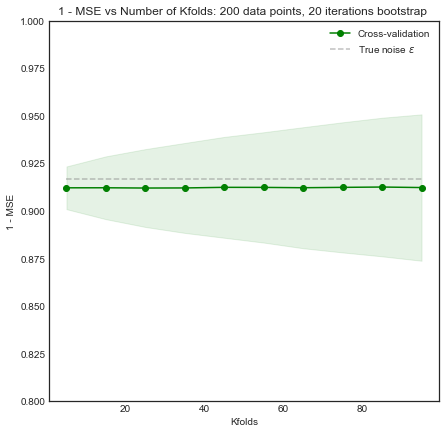

In [164]:
plt.figure(figsize = (7,7))
plt.fill_between(split_range, 1 - (Test_Mean_MSE2 - Test_Std_MSE2),
                 1 - (Test_Mean_MSE2 + Test_Std_MSE2), alpha=0.1, color="g")

plt.plot(split_range, 1 - Test_Mean_MSE2, 'o-', color="g",
         label="Cross-validation")

plt.hlines(1 - 1/12 , min(split_range),max(split_range), linestyle = '--', color = 'gray', alpha = .5, label = 'True noise $\epsilon$')
plt.legend(loc="best")
plt.ylim(0.8,1)
plt.ylabel('1 - MSE')
plt.xlabel('Kfolds')
plt.title('1 - MSE vs Number of Kfolds: 200 data points, 20 iterations bootstrap ')

### Printing the standard deviation for each K value 

In [165]:
pd.DataFrame(data = {'K = ':split_range,'Mean MSE': Test_Mean_MSE2,'Std MSE': Test_Std_MSE2 })

,K =,Mean MSE,Std MSE
0,5,0.087790,0.011228
1,15,0.087769,0.016517
2,25,0.087910,0.020465
3,35,0.087858,0.023648
4,45,0.087539,0.026507
5,55,0.087574,0.029003
6,65,0.087742,0.031815
7,75,0.087553,0.034209
8,85,0.087383,0.036430
9,95,0.087655,0.038469


### Larger dataset - 500 points 

In [152]:
#Utility variables
Test_Mean_MSE1, Test_Std_MSE1 = [],[]
Test_Mean_MSE2, Test_Std_MSE2 = [],[]
split_range = np.arange(5,500,25)

for s in split_range:

    for i in range(20):
        Test_MSE_list = []
        rs = ShuffleSplit(n_splits=1, train_size = 500, test_size=1)
        rs.get_n_splits(X)
        for subset_index, _ in rs.split(X):
            X_subset, Y_subset, = X[subset_index],Y[subset_index]
        
        #Loop over kfold splits
        kf = KFold(n_splits = s)

        for train_index, test_index in kf.split(X_subset):
            X_train, X_test = X_subset[train_index], X_subset[test_index]
            y_train, y_test = Y_subset[train_index], Y_subset[test_index]
            
            pipeline = Pipeline([('polynomialfeatures', PolynomialFeatures(degree=6, include_bias=True, interaction_only=False)),
             ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])
            pipeline.fit(X_train,y_train)
            Test_MSE_list.append(mean_squared_error(y_test, pipeline.predict(X_test)))
        
        Test_Mean_MSE1.append(np.mean(Test_MSE_list))
        Test_Std_MSE1.append(np.std(Test_MSE_list))       

    Test_Mean_MSE2.append(np.mean(Test_Mean_MSE1))
    Test_Std_MSE2.append(np.mean(Test_Std_MSE1))

Test_Mean_MSE2  = np.asarray(Test_Mean_MSE2)
Test_Std_MSE2  = np.asarray(Test_Std_MSE2)

Text(0.5,1,'1 - MSE vs Number of Kfolds: 500 data points ')

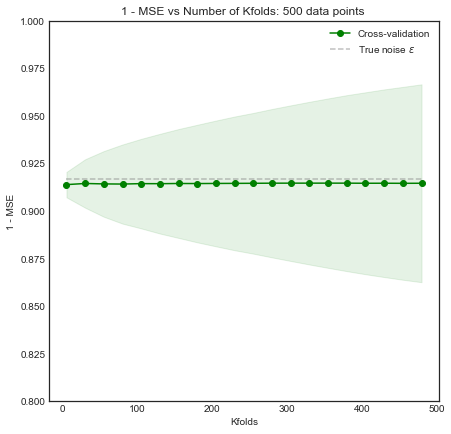

In [154]:
plt.figure(figsize = (7,7))
plt.fill_between(split_range, 1 - (Test_Mean_MSE2 - Test_Std_MSE2),
                 1 - (Test_Mean_MSE2 + Test_Std_MSE2), alpha=0.1, color="g")

plt.plot(split_range, 1 - Test_Mean_MSE2, 'o-', color="g",
         label="Cross-validation")

plt.hlines(1 - 1/12 , min(split_range),max(split_range), linestyle = '--', color = 'gray', alpha = .5, label = 'True noise $\epsilon$')
plt.legend(loc="best")
plt.ylim(0.8,1)
plt.ylabel('1 - MSE')
plt.xlabel('Kfolds')
plt.title('1 - MSE vs Number of Kfolds: 500 data points ')